# ch11 메타학습

## 11.1 메타러닝과 퓨삿러닝

- 메타학습(Meta-laerning) : 메타 데이터라고 불리는 방대한 데이터를 이용해 학습하는 방법을 학습하여 적은 데이터로도 새로운 문제를 빠르게 풀 수 있게 하는 방법
- 퓨삿러닝(Few-shot learning) : 적은 양의 데이터를 가진 여러가지 업무(Task)세트가 존재할 때 그 업무 세트를 가지고 학습하는 방법을 학습하여 새로운 업무에 대해서 적응 양의 데이터라도 빠르게 학습할 수 있는 메타 학습 방법 중 하나

![스크린샷 2024-02-02 오후 12.59.58.png](<attachment:스크린샷 2024-02-02 오후 12.59.58.png>)


- 메타 훈련 데이터 : 사전 지식으로 생각할 수 있는 이미 가지고 있는 데이터
- 메타 테스트 데이터 : 한 번도 보지 못한 데이터
- **메타 훈련 데이터에 있는 정보는 메타 테스트 데이터에는 존재하지 않는다**


</br>


- 서포트 세트 : 학습에 직접 사용되는 세트
- 쿼리 세트 : 모델 업데이트를 위해 사용되는 세트 


</br>


- 최적화 기반 메타 학습 (Optimization-based meta-Learning) : 메타 훈련 데이터를 통해 어떤 식으로 모델을 최적화해야 일반적인 모델 파라미터를 얻을 수 있는지 확인하는 방법
    - MAML(Model-Agnostic Meta-Learning) : 각 업무마다 최적 파라미터를 빠르게 찾을 수 있도록 하는 초기 모델 파라미터를 만드는 방법, 모델 구조의 제약 없이 사용 가능(회귀,분류,강화학습까지)
    ![스크린샷 2024-02-02 오후 1.05.42.png](<attachment:스크린샷 2024-02-02 오후 1.05.42.png>)
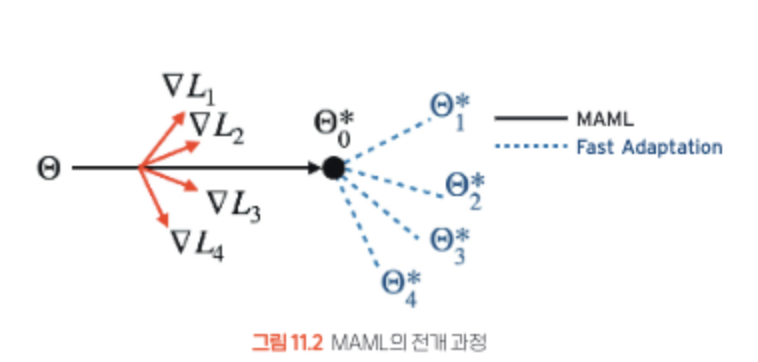
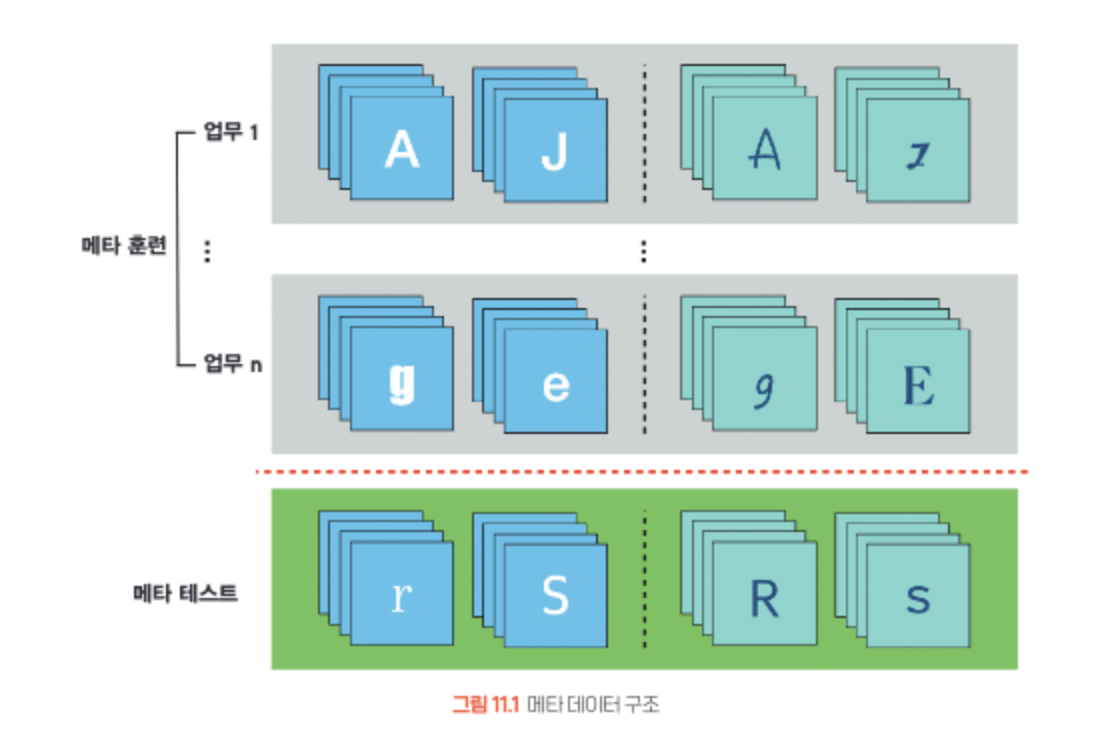

## 11.2 MAML - 회귀문제

In [54]:
# 라이브러리, GPU 연산 확인
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [55]:
# 데이터 생성 클래스 정의하기
class TensorData(Dataset):
    def __init__(self,x_data,y_data):
        self.x_data = x_data
        self.y_data = y_data
        self.len = self.y_data.shape[0]
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    def __len__(self):
        return self.len
    
# 사인함수 데이터를 이용
class SinusoidalFunction:
    def __init__(self,x_range=5,k=5,num_tasks=4): # self. 를 붙여주는 이유 : 클래스 내에서 변수가 활용될 수 있도록
        self.x_range = x_range # [-x_range,x_range] 정의역의 범위
        self.pi = torch.acos(torch.zeros(1)).item()*2
        self.k = k # 각 함수의 데이터 포인트 개수
        self.num_tasks = num_tasks # 함수 개수에 해당하는 업무 수 

    def meta_train_data(self): # 메타 학습 데이터를 만드는 함수 정의
        x_points = 2*self.x_range*(torch.rand((self.num_tasks,2*self.k))-0.5) # S and Q
        y_points = torch.tensor([],dtype=torch.float)
        for x in x_points:
            a= 4*(torch.rand(1)+0.1)
            b= self.pi * torch.rand(1) # [0,pi]
            y= a * torch.sin(x.view(1,-1)+b)
            y_points = torch.cat((y_points,y),0)
        taskset = TensorData(x_points,y_points)
        trainloader = torch.utils.data.DataLoader(taskset, batch_size=1)
        return trainloader
    
    def meta_eval_data(self, k): # 메타 테스트 데이터도 각 포인트 데이터를 생성
        x_points = 2*self.x_range*(torch.rand(2*k)-0.5)
        a = 4 * (torch.rand(1)+0.1)
        b = self.pi * torch.rand(1) # [0,pi]
        y_points = a * torch.sin(x_points + b)
        sup_x = x_points[:k]
        sup_y = y_points[:k]
        que_x = x_points[k:]
        que_y = y_points[k:]
        x = torch.linspace(-self.x_range,self.x_range,200) # 검증확인을 위해 점 200개에 대한 실제 그래프 데이터를 생성
        y = a*torch.sin(x+b)
        return sup_x,sup_y,que_x,que_y,x,y

In [56]:
# 데이터 생성하기
k= 5 # 2000개의 사인함수마다 5개의 점만 알고 있다고 가정하고 데이터를 생성
num_tasks = 2000
sine = SinusoidalFunction(k=k, num_tasks=num_tasks)
trainloader = sine.meta_train_data()

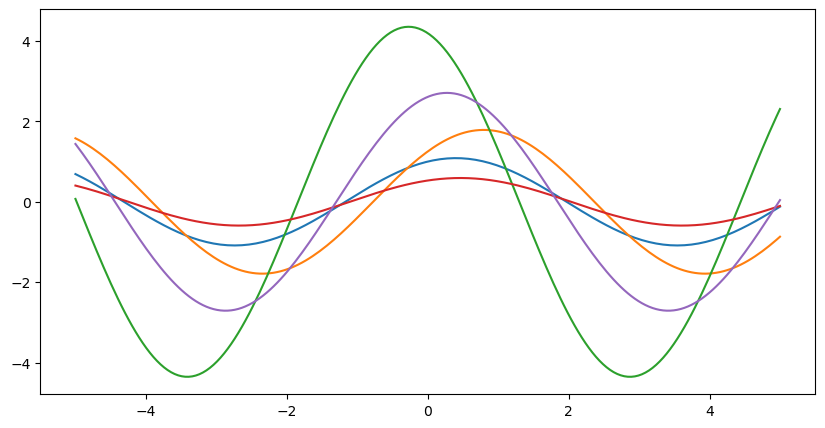

In [57]:
# 데이터 함수 확인하기
plt.figure(figsize=(10,5))
for i in range(5):
    _,_,_,_,x,y = sine.meta_eval_data(5)
    plt.plot(x,y)
plt.show()
plt.close()

In [58]:
# 모델 구축하기
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1,40) # 입력층, 은닉층2개, 출력층으로 구성된 MLP로 구성
        self.fc2 = nn.Linear(40,40)
        self.fc3 = nn.Linear(40,1)

    def forward(self,x):
        x=F.relu(self.fc1(x)) # MAML은 각 업무마다 모델 업데이트가 일어나고, 모든 업무에서 구해진 손실함수를 바탕으로 모델 업데이트가 별도로 일어남
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
    def parameterised(self,x, weights): # 중복 계산을 방지하고 모델의 파라미터를 직접 받아 계산할 수 있도록 함
        x=F.relu(F.linear(x,weights[0],weights[1]))
        x=F.relu(F.linear(x,weights[2],weights[3]))
        x=F.linear(x,weights[4], weights[5])
        return x

In [59]:
class MAML:
    def __init__(self, trainloader, k, alpha=1e-2, beta=1e-3):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.k = k
        self.model = Regressor().to(self.device)
        self.weights = list(self.model.parameters())
        self.trainloader = trainloader
        self.beta = beta
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=alpha)

    def inner_loop(self, data):
        inputs, values = data[0].to(self.device), data[1].to(self.device)
        support_x = inputs[:, :self.k].T
        support_y = values[:, :self.k].T
        query_x = inputs[:, self.k:].T
        query_y = values[:, self.k:].T

        outputs = self.model.parameterised(support_x, self.weights)
        loss = self.criterion(outputs, support_y)
        grad = torch.autograd.grad(loss, self.weights)
        updated_weights = [w - self.beta * g for w, g in zip(self.weights, grad)]

        outputs = self.model.parameterised(query_x, updated_weights)
        inner_loss = self.criterion(outputs, query_y)
        return inner_loss

    def meta_train(self, num_epochs):
        n = len(self.trainloader)
        loss_list = []

        for epoch in range(num_epochs):
            self.optimizer.zero_grad()
            outer_loss = 0

            for data in self.trainloader:
                outer_loss += self.inner_loop(data)

            outer_loss /= n  # 평균 계산
            outer_loss.backward()
            self.optimizer.step()

            loss_list.append(outer_loss.item())

            if epoch % 10 == 0:
                print(epoch, outer_loss.item())

        return loss_list


In [60]:
# 메타학습 수행하기
maml = MAML(trainloader, k=k)
loss = maml.meta_train(201) 

0 4.011923789978027
10 2.878682851791382
20 2.7089571952819824
30 2.6315746307373047
40 2.5485634803771973
50 2.4840168952941895
60 2.4306631088256836
70 2.387951612472534
80 2.3450496196746826
90 2.3025782108306885
100 2.2680909633636475
110 2.248544931411743
120 2.233018159866333
130 2.2228262424468994
140 2.213545799255371
150 2.203582286834717
160 2.1933703422546387
170 2.181591272354126
180 2.1800742149353027
190 2.163968324661255
200 2.1563754081726074


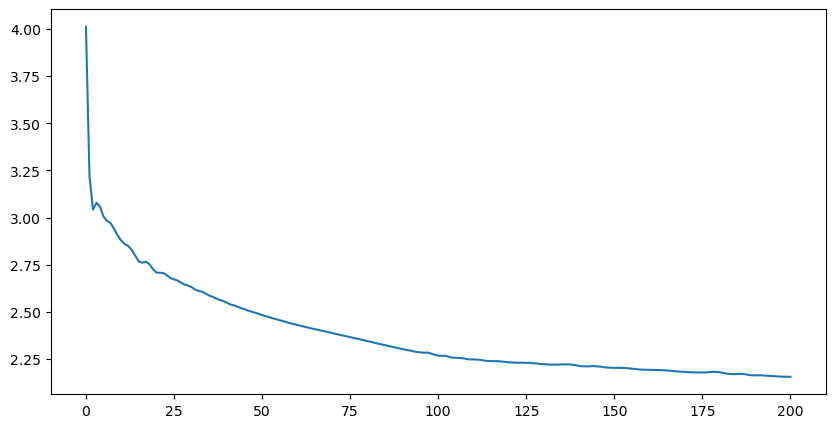

In [61]:
# 메타 학습 손실 함수 그래프 그리기 
plt.figure(figsize = (10,5))
plt.plot(loss)
plt.show()

In [62]:
# 메타 학습 검증 함수 정의하기
def inference(sup_x, sup_y, x, y, model):
    with torch.no_grad():
        pred = model(x.view(-1, 1).to(device))
        plt.figure(figsize=(10, 5))
        plt.plot(x.cpu().detach(), pred.cpu().detach(), '-b')
        plt.plot(sup_x.cpu().detach(), sup_y.cpu().detach(), '.g')
        plt.plot(x, y, '-r')
        plt.legend(['prediction', 'actual points', 'actual graph'])
        plt.show()
        plt.close()


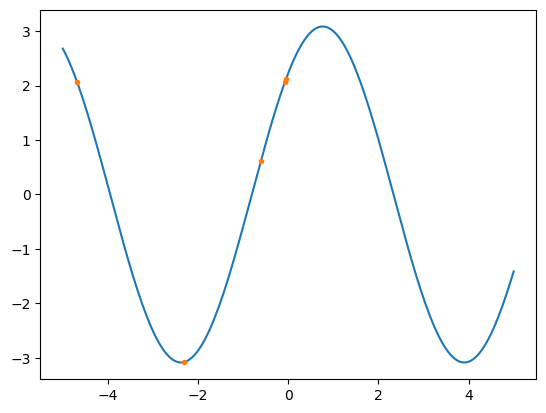

In [63]:
# 메타 테스트 데이터 생성하기 
sup_x, sup_y ,_,_,x,y = sine.meta_eval_data(5)
plt.plot(x,y)
plt.plot(sup_x,sup_y,'.')
plt.show()

In [64]:
# 메타 학습 검증하기 
pre = maml.model()
criterion = nn.MSELoss()
optimizer = optim.Adam(pre.parameters(),lr= 1e-3)
num_epochs= 501
for i in range(num_epochs):
    optimizer.zero_grad()
    outputs = pre(sup_x.view(-1,1).to(device))
    loss = criterion(outputs, sup_y.view(-1,1).to(device))
    loss.backward()
    optimizer.step()
    if i ==0 :
        inference(sup_x,sup_y,x,y,pre)
    elif i == num_epochs-1 : 
        inference(sup_x,sup_y,x,y,pre)

TypeError: Regressor.forward() missing 1 required positional argument: 'x'

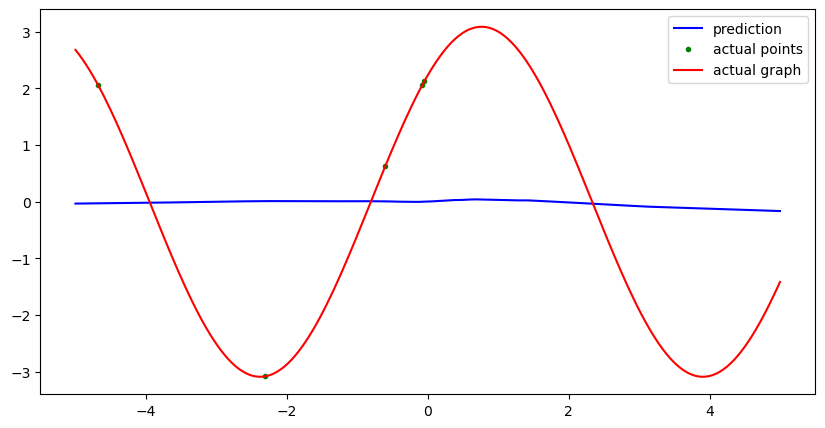

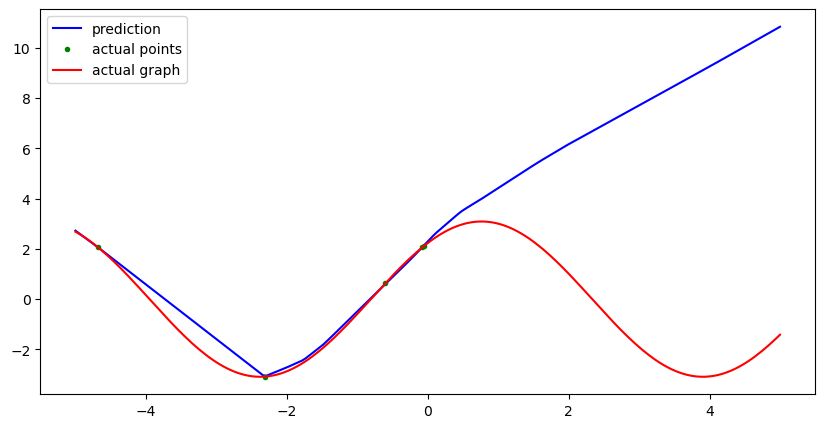

In [65]:
# 기본적인 지도 학습 진행하기 (메타학습 없이 5개의 서포트 데이터로 학습을 진행한다)

net = Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr = 1e-3)
num_epochs= 501
for i in range(num_epochs):
    optimizer.zero_grad()
    outputs = net(sup_x.view(-1,1).to(device))
    loss = criterion(outputs, sup_y.view(-1,1).to(device))
    loss.backward()
    optimizer.step()
    if i==0:
        inference(sup_x,sup_y,x,y,net)
    elif i == num_epochs-1:
        inference(sup_x,sup_y,x,y,net)